In [1]:
%load_ext autoreload
%autoreload 2

from propose.datasets.rat7m.loaders import load_cameras, load_mocap
from propose.poses import Rat7mPose
from pathlib import Path

import numpy as np
from tqdm import tqdm

import imageio

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib import animation

In [3]:
mocap_path = f"../../data/rat7m/mocap/mocap-s4-d1.mat"
vid_path = f"../../data/rat7m/movies/s4-d1/s4-d1-camera4-0.mp4"

vid = imageio.get_reader(vid_path)

## Remove frames with nans

In [4]:
cameras = load_cameras(mocap_path)
mocap = load_mocap(mocap_path)

pose = mocap

mask = np.invert(np.isnan(pose).any(1).any(1))

pose = pose[mask]

np.array(pose._edge("HeadF", "HeadB"))

array([[[-219.0188446 , -213.56304932, -213.24876404, ...,
         -143.6754303 , -143.65098572, -143.54769897],
        [-202.38188171, -198.31828308, -198.32516479, ...,
         -153.6410675 , -153.35192871, -153.22558594]],

       [[  31.07101059,   26.59701157,   25.40685844, ...,
          180.1421814 ,  179.66021729,  180.25765991],
        [  20.20547676,   16.88157845,   16.23282814, ...,
          172.70890808,  172.24945068,  172.30340576]],

       [[ 107.86932373,  112.40010071,  115.86945343, ...,
           59.84708023,   59.21270752,   59.80217361],
        [ 103.29882812,  102.8848114 ,  105.46248627, ...,
           76.22170258,   75.75984192,   76.11906433]]])

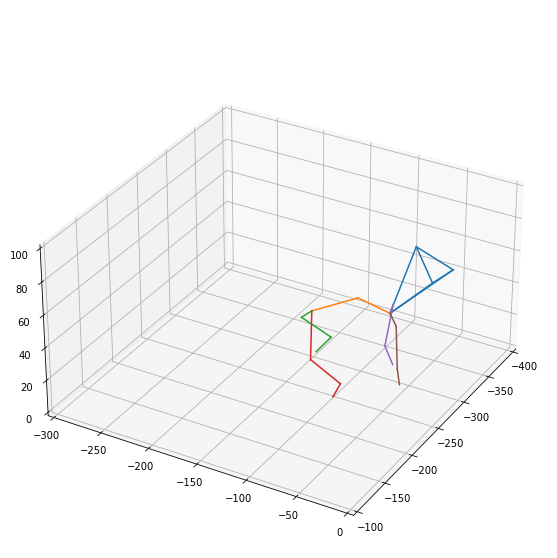

In [5]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1, projection="3d")
ax1.get_proj = lambda: np.dot(Axes3D.get_proj(ax1), np.diag([1, 1, 0.75, 1]))
ax1.view_init(30, 30)
ax1.set_xlim(-400, -100)
ax1.set_ylim(-300, 0)
ax1.set_zlim(0, 100)

pose[0].plot(ax1)
plt.show()

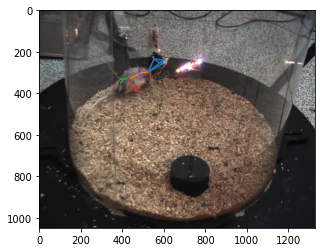

In [6]:
camera = cameras["Camera4"]
pose2D = Rat7mPose(camera.proj2D(pose))

frame_idx = camera.frames.squeeze()[mask][0]
im = vid.get_data(frame_idx)

plt.figure()
ax = plt.gca()
plt.imshow(im)
pose2D[0].plot(ax)
plt.show()

In [8]:
cameras = load_cameras(mocap_path)
camera = cameras["Camera4"]
camera.frames = camera.frames.squeeze()[mask]
pose_idx = 0

frame_idx = camera.frames.squeeze()[pose_idx]
im = vid.get_data(frame_idx)

pose = mocap
mask = np.invert(np.isnan(pose).any(1).any(1))
pose = pose[mask]
pose2D = Rat7mPose(camera.proj2D(pose))

fig = plt.figure(figsize=(20, 10))

ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax1.get_proj = lambda: np.dot(Axes3D.get_proj(ax1), np.diag([1, 1, 0.75, 1]))
ax1.view_init(30, 30)
ax1.set_xlim(-400, -100)
ax1.set_ylim(-300, 0)
ax1.set_zlim(0, 100)

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title("Camera 4")
plt.axis("off")

img = ax2.imshow(im)
animate1 = pose.animate(ax1)
animate2 = pose2D.animate(ax2)

plt.close(fig)


def animate(i):
    frame_idx = camera.frames.squeeze()[pose_idx + i]
    im = vid.get_data(frame_idx)

    img.set_data(im)

    animate1(i)
    animate2(i)


ani = animation.FuncAnimation(fig, animate, frames=100)

Writer = animation.writers["ffmpeg"]
writer = Writer(fps=30, metadata=dict(artist="Me"), bitrate=-1)

pbar = tqdm(total=100, position=0)

ani.save(
    "walk_cam_4_sub.mp4", writer=writer, progress_callback=lambda i, n: pbar.update(1)
)

100%|██████████| 100/100 [00:32<00:00,  3.92it/s]